In [7]:

#This two functions are used to get the number of fragments per group and the top fragments per group for each library

import pandas as pd

def get_fragments_per_group(df_list: list, library_names: list, group_col: str, count_col) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        # add the number of unique elements from the count column with each group
        new_row = df.groupby(group_col).agg({count_col: 'nunique'}).reset_index()
        # rename count column
        new_row.rename(columns={count_col: 'count'}, inplace=True)
        new_row['library'] = library_names[i]
        new_df = pd.concat([new_df, new_row])
        
    # Sort the dataframe by the count column
    new_df.sort_values(by='count', ascending=False, inplace=True)
        
    return new_df


def get_top_fragments_per_group(df_list: list, library_names: list, group_col: str, value_col:str, number_of_top: int=10) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df['library'] = library_names[i]
        df = df[[group_col, value_col, 'library','LUTnr', 'Peptide', 'Sequence']]
        new_df = pd.concat([new_df, df])
    new_df.sort_values(by=[group_col,value_col], ascending=[True,False], inplace=True)
    # add the number of top number of rows with the highest values from the value column with each group
    temp_df = new_df.groupby(group_col).apply(lambda x: x.nlargest(number_of_top, value_col)).reset_index(drop=True)
        
    # Sort the dataframe by the count column
    temp_df.sort_values(by=[group_col,value_col], ascending=[True,False], inplace=True)
    
    return temp_df

In [8]:
# Function to transform the peptide dataframe to a more readable format to check how many barcodes are found in each group
def transform_peptide_dataframe(df, column_list:list=None, remove_columns: list=None):
    # Get unique peptides
    unique_peptides = df["Peptide"].unique()
    
    # Get unique groups
    unique_groups = df["Group"].unique()
    
    # Create a new dataframe with Peptide as index
    peptide_df = pd.DataFrame(index=unique_peptides)
    
    # Iterate through each unique group
    for group in unique_groups:
        # Filter rows belonging to the current group
        group_df = df[df["Group"] == group]
        
        # Aggregate BC_count for each peptide in the group
        peptide_counts = group_df.groupby("Peptide")["BC_count"].sum()
        
        # Merge with the main peptide_df, filling missing values with 0
        peptide_df[group] = peptide_df.index.map(peptide_counts).fillna(0)
        
        # set the values to integer
        peptide_df[group] = peptide_df[group].astype(int)
    
    # Create the "Total" column to count in how many groups each peptide appears
    peptide_df["Found in"] = (peptide_df[unique_groups] > 0).sum(axis=1)
    
    # Reset index so that Peptide is a column
    peptide_df.reset_index(inplace=True)
    peptide_df.rename(columns={"index": "Peptide"}, inplace=True)
    
    cols = peptide_df.columns.tolist()
    cols = cols[:1] + cols[-1:] + cols[1:-1]
    peptide_df = peptide_df[cols]
    
    # if there is a column list move all the columns to the front
    if column_list:
        cols = peptide_df.columns.tolist()
        for col in column_list:
            cols.remove(col)
        cols = column_list + cols
        peptide_df = peptide_df[cols]
        # sort the df by all the columns
        column_list.remove("Peptide")
        # reverse the order of the columns
        column_list.reverse()
        peptide_df.sort_values(by=column_list, ascending=False, inplace=True)
    
    if remove_columns:
        peptide_df.drop(columns=remove_columns, inplace=True)
    
    # remove the index
    peptide_df.reset_index(drop=True, inplace=True)
    
    return peptide_df


In [9]:
# Read the dataframes into dataframes

import pandas as pd

df_p005 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p005_no_starcode/final_fragments_summary.csv")
df_p006 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p006_no_starcode/final_fragments_summary.csv")
df_p007 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p007_no_starcode/final_fragments_summary.csv")
brave_14aa = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/Brave/final_fragments_summary.csv")
brave_22aa = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/Brave_22aa/final_fragments_summary.csv")

In [10]:
# Creating the organized dataframe for the peptide dataframe
temp_df = transform_peptide_dataframe(df_p005, ["Peptide", "Found in", "Plasmid_Library", "DNAse_resistant_AAVs", "Infective_AAVs"])
temp_df.to_csv("plots/librarys/tables/p005_peptide.csv", index=False)
temp_df = transform_peptide_dataframe(df_p006, ["Peptide", "Found in", "Plasmid_Library", "DNAse_resistant_AAVs", "Infective_AAVs"])
temp_df.to_csv("plots/librarys/tables/p006_peptide.csv", index=False)
temp_df = transform_peptide_dataframe(df_p007, ["Peptide", "Found in", "Plasmid_Library", "DNAse_resistant_AAVs", "Infective_AAVs"])
temp_df.to_csv("plots/librarys/tables/p007_peptide.csv", index=False)
temp_df = transform_peptide_dataframe(brave_14aa,
                                        ["Peptide", "Found in", "Plasmid_Library", "DNAse_resistant_AAVs", "Infective_AAVs"],
                                        ["DNA_AAVlib_DNAse_30cpc","DNA_AAVlib_DNAse_3cpc","DNA_pscAAVlib_Prep2"])
temp_df.to_csv("plots/librarys/tables/Brave_14aa_peptide.csv", index=False)
temp_df = transform_peptide_dataframe(brave_22aa,
                                        ["Peptide", "Found in", "Plasmid_Library", "DNAse_resistant_AAVs", "Infective_AAVs"],
                                        ["DNA_AAVlib_DNAse_30cpc","DNA_AAVlib_DNAse_3cpc","DNA_pscAAVlib_Prep2"])
temp_df.to_csv("plots/librarys/tables/Brave_22aa_peptide.csv", index=False)

In [6]:
# Analyze the dataframes to see the number of fragments that have more than one barcode matching to them
def barcode_counts_analysis(df: pd.DataFrame, group_col: str, count_col: str) -> pd.DataFrame:
    # for each Group show the number of fragments that have a BC_count > 1 and 1 
    df['BC_count_label'] = df[count_col].apply(lambda x: 'BC_count > 1' if x > 1 else 'BC_cout = 1')
    # for each group get the number of fragments that have a BC_count > 1 and 1
    # sort by the BC_count > 1 count column
    df = df.groupby([group_col, 'BC_count_label']).agg({count_col: 'count'}).unstack().fillna(0)
    df.columns = df.columns.droplevel()
    df['total'] = df.sum(axis=1)
    df.sort_values(by='total', ascending=False, inplace=True)
    return df

barcode_counts_analysis(df_p005, 'Group', 'BC_count')

#barcode_counts_analysis(df_p006, 'Group', 'BC_count')

#barcode_counts_analysis(df_p007, 'Group', 'BC_count')

#barcode_counts_analysis(brave_14aa, 'Group', 'BC_count')

#barcode_counts_analysis(brave_22aa, 'Group', 'BC_count')


BC_count_label,BC_count > 1,BC_cout = 1,total
Group,,,
Plasmid_Library,39705,17,39722
DNAse_resistant_AAVs,39548,111,39659
Infective_AAVs,5543,9362,14905
Sox10+_IC,3341,7555,10896
Sox10-_striatum,3274,7580,10854
Sox10+_striatum,2746,7184,9930
Sox10-_IC,2695,7193,9888
Sox10+_sort_pooled,273,2364,2637
Sox10+_midbrain,149,1803,1952


In [15]:
# Here we can filtere the dataframes to remove the fragments that have only one barcode matching to them form the Plasmid Library and DNAse resistant AAVs groups

df_p005_filtered = df_p005[~(((df_p005['Group'] == 'Plasmid_Library') | 
                                (df_p005['Group'] == 'DNAse_resistant_AAVs')) & 
                                (df_p005['BC_count'] == 1))]
df_p006_filtered = df_p006[~(((df_p006['Group'] == 'Plasmid_Library') |
                                (df_p006['Group'] == 'DNAse_resistant_AAVs')) & 
                                (df_p006['BC_count'] == 1))]
df_p007_filtered = df_p007[~(((df_p007['Group'] == 'Plasmid_Library') |
                                (df_p007['Group'] == 'DNAse_resistant_AAVs')) & 
                                (df_p007['BC_count'] == 1))]
brave_14aa_filtered = brave_14aa[~(((brave_14aa['Group'] == 'Plasmid_Library') |
                                (brave_14aa['Group'] == 'DNAse_resistant_AAVs')) & 
                                (brave_14aa['BC_count'] == 1))]
brave_22aa_filtered = brave_22aa[~(((brave_22aa['Group'] == 'Plasmid_Library') |
                                (brave_22aa['Group'] == 'DNAse_resistant_AAVs')) & 
                                (brave_22aa['BC_count'] == 1))]

In [7]:
# Function to evaluate the top fragments for each group and create a summary output table
def evaluate_top_fragments(df: pd.DataFrame, top_nr: int):
    # Create a new dataframe to store the results
    new_df = pd.DataFrame()
    # For every group in the dataframe add all LUTnr that are in the top 100 as a new column named by the group name
    for group in df['Group'].unique():
        lutnr = list(df[df['Group'] == group]['library'])
        library = list(df[df['Group'] == group]['LUTnr'])
        new_col = [nr + "_" + lib for nr, lib in zip(lutnr, library)]
        new_df[group] = new_col
    # create a new dictionary than loop through every column and give a sequcne a count based on its possition where the top one get the highest count and the last one the lowest
    score_dict = {}
    for col in new_df.columns:
        for i, value in enumerate(new_df[col]):
            # if the value is not in the dictionary add it
            if value not in score_dict:
                score_dict[value] = 0
            # add the score to the value
            score_dict[value] += i
    # sort the dictionary by the score descending
    score_dict = dict(sorted(score_dict.items(), key=lambda item: item[1], reverse=True))
    # extract the top nr from the dictionary
    top_dict = list(score_dict.keys())[:top_nr]
    # add a new column to the new dataframe with the score
    new_df['Overall'] = top_dict
    # move the score column to the front
    cols = new_df.columns.tolist() 
    cols = cols[-1:] + cols[:-1]
    new_df = new_df[cols]
    return new_df


In [ ]:
# Here we chose the number of top fragments that we want for each group and the value column that we want to use
# Then we create a new dataframe with the top fragments for each group and save it to a csv file

top_nr = 100
value_col = 'RNAcount' #BC_adjusted_count_ratio' or 'RNAcount' or 'BC_count' or 'RNAcount_ratio'
top_df = get_top_fragments_per_group([df_p005, df_p006, df_p007],["p005", "p006", "p007"], 'Group', value_col, top_nr)
eval_top_df = evaluate_top_fragments(top_df, top_nr)
top_df.to_csv(f"plots/tops/top_{top_nr}_{value_col}_fragments.csv", index=False)
eval_top_df.to_csv(f"plots/tops/top_{top_nr}_{value_col}_list.csv", index=False)

/tmp/ipykernel_3893089/2611801474.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_df = new_df.groupby(group_col).apply(lambda x: x.nlargest(number_of_top, value_col)).reset_index(drop=True)


In [63]:
# checking the number of fragments that overlap between the libraries
# Define the input file (regular FASTQ, not gzipped)
input_p005 = "/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p005/SortedFragments.txt"
input_p007 = "/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p007/SortedFragments.txt"
# Extract sequences
sequences_p005 = []
sequences_p007 = []

with open(input_p005, "r") as handle:  # Use open instead of gzip.open
    # Read the file line by line
    for line in handle:
        # Remove leading/trailing whitespaces
        line = line.strip()
        # Skip empty lines
        if not line:
            continue
        # Skip header lines
        if line.startswith("S"):
            continue
        # Store the sequence
        sequences_p005.append(line)
        
with open(input_p007, "r") as handle: 
    for line in handle:
        line = line.strip()
        if not line:
            continue
        if line.startswith("S"):
            continue
        sequences_p007.append(line)
        
print(f"Number of sequences in p005: {len(sequences_p005)}")
print(f"Number of sequences in p007: {len(sequences_p007)}")

# confert list to a set
sequences_p005 = set(sequences_p005)
sequences_p007 = set(sequences_p007)

# Find the intersection
common_sequences = sequences_p005.intersection(sequences_p007)
print(f"Number of common sequences: {len(common_sequences)}")

Number of sequences in p005: 41980
Number of sequences in p007: 117126
Number of common sequences: 32403


In [8]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_venn_diagram(set1, set2, labels=("Set 1", "Set 2"), title="Venn Diagram"):
    """
    Plots a Venn diagram for two sets, displaying percentages instead of raw counts.
    The count for elements only in the second set is hidden.

    Parameters:
    - set1, set2: The two sets of sequences.
    - labels: Tuple of two strings representing the labels for the sets.
    - title: Title of the plot.
    """
    # Compute set sizes
    only_set1 = len(set1 - set2)  
    only_set2 = len(set2 - set1)  
    intersection = len(set1 & set2)  
    
    # Calculate total for percentage conversion
    total = only_set1 + only_set2 + intersection
    if total == 0:
        print("Warning: Both sets are empty, no Venn diagram will be displayed.")
        return

    # Compute percentages
    percent_set1 = (only_set1 / total) * 100
    percent_intersection = (intersection / total) * 100

    # Define subset dictionary (hide only_set2)
    subsets = {
        '10': percent_set1,  # Percentage of elements only in set1
        '01': 0,  # Hide count for set2 alone by setting it to zero
        '11': percent_intersection  # Percentage of elements in both sets
    }

    # Create the Venn diagram
    plt.figure(figsize=(6, 6))
    
    colors = ['#00007a','#b6b6ff']
    venn = venn2(subsets=subsets, set_labels=labels, set_colors=colors, alpha=1)

    # Customize text properties
    for text in venn.set_labels:
        if text:
            text.set_text("")
            text.set_fontsize(12)
    for i, text in enumerate(venn.subset_labels):
        if text:
            if i == 1:  # Index 1 corresponds to 'only_set2' which we want to hide
                text.set_text("")
            else:
                text.set_text(f"{float(text.get_text()):.1f}%")  # Convert to percentage format
                text.set_fontsize(12)
                text.set_color('white')

    # Show the plot
    plt.title(title, fontsize=14)
    plt.show()


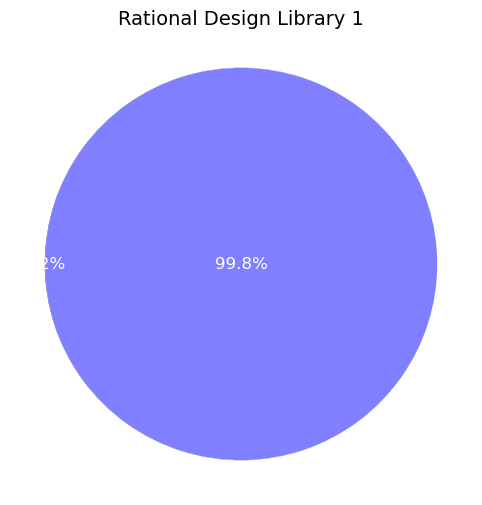

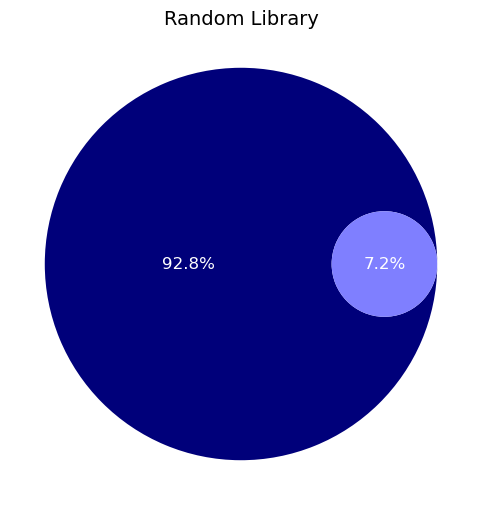

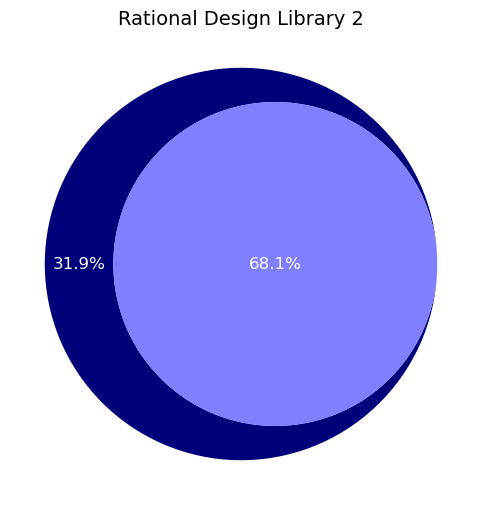

In [11]:
p005_Plasmid_Library = set(df_p005[df_p005['Group'] == 'Plasmid_Library']['Peptide'])
p006_Plasmid_Library = set(df_p006[df_p006['Group'] == 'Plasmid_Library']['Peptide'])
p007_Plasmid_Library = set(df_p007[df_p007['Group'] == 'Plasmid_Library']['Peptide'])

p005_DNAse_resistant = set(df_p005[df_p005['Group'] == 'DNAse_resistant_AAVs']['Peptide'])
p006_DNAse_resistant = set(df_p006[df_p006['Group'] == 'DNAse_resistant_AAVs']['Peptide'])
p007_DNAse_resistant = set(df_p007[df_p007['Group'] == 'DNAse_resistant_AAVs']['Peptide'])

plot_venn_diagram(p005_Plasmid_Library, p005_DNAse_resistant, ('Plasmid Library', 'Capable to Assemble into a Functional Capsid'), 'Rational Design Library 1')

plot_venn_diagram(p006_Plasmid_Library, p006_DNAse_resistant, ('Plasmid Library', 'Capable to Assemble into a Functional Capsid'), 'Random Library')

plot_venn_diagram(p007_Plasmid_Library, p007_DNAse_resistant, ('Plasmid Library', 'Capable to Assemble into a Functional Capsid'), 'Rational Design Library 2')

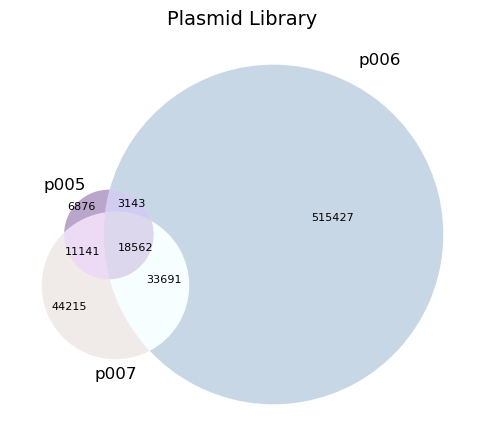

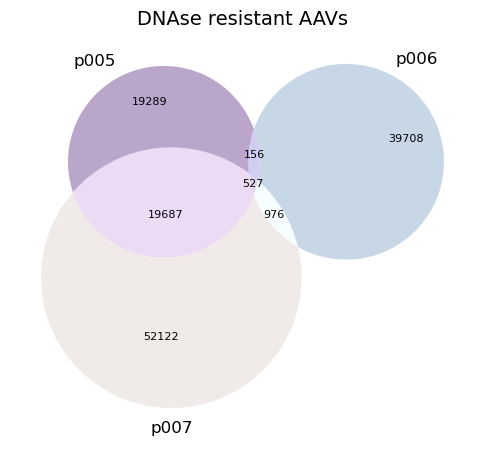

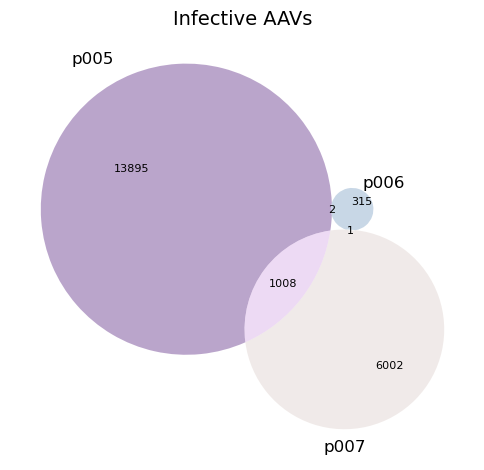

In [12]:
from plotting_functions import plot_venn_diagram
# Get the number of Peptides we actually have in the libraries
p005_Plasmid_Library = set(df_p005[df_p005['Group'] == 'Plasmid_Library']['Peptide'])
p006_Plasmid_Library = set(df_p006[df_p006['Group'] == 'Plasmid_Library']['Peptide'])
p007_Plasmid_Library = set(df_p007[df_p007['Group'] == 'Plasmid_Library']['Peptide'])

p005_DNAse_resistant = set(df_p005[df_p005['Group'] == 'DNAse_resistant_AAVs']['Peptide'])
p006_DNAse_resistant = set(df_p006[df_p006['Group'] == 'DNAse_resistant_AAVs']['Peptide'])
p007_DNAse_resistant = set(df_p007[df_p007['Group'] == 'DNAse_resistant_AAVs']['Peptide'])

p005_Infective_AAVs = set(df_p005[df_p005['Group'] == 'Infective_AAVs']['Peptide'])
p006_Infective_AAVs = set(df_p006[df_p006['Group'] == 'Infective_AAVs']['Peptide'])
p007_Infective_AAVs = set(df_p007[df_p007['Group'] == 'Infective_AAVs']['Peptide'])

plot_venn_diagram(p005_Plasmid_Library, p006_Plasmid_Library, p007_Plasmid_Library, ('p005', 'p006', 'p007'), 'Plasmid Library')

plot_venn_diagram(p005_DNAse_resistant, p006_DNAse_resistant, p007_DNAse_resistant, ('p005', 'p006', 'p007'), 'DNAse resistant AAVs')

plot_venn_diagram(p005_Infective_AAVs, p006_Infective_AAVs, p007_Infective_AAVs, ('p005', 'p006', 'p007'), 'Infective AAVs')



In [13]:
# Selecting the data that we want to use for the plot

df = df_p005
# for p005 we can extract the GeneName from the Origion_seq column
if df['Origion_seq'].str.contains(',').any():
    df['GeneName'] = df['Origion_seq'].str.split(',').str[5]

In [14]:
# Here we creating a new dataframe that holds the number of unique variants in each group

# get the number of unique LUTnr in each group of the dataframe
df.groupby('Group')['LUTnr'].nunique().sort_values(ascending=False)

# create a new dataframe with Group and number of fragments in that group
group_df = df.groupby('Group').size().reset_index(name='count')

# Sort the dataframe by the count column in descending order
group_df.sort_values(by='count', ascending=False, inplace=True)

# Check if Infectiv_AAV is a subset of DNA_resistant_AAV and DNA_sensitive_AAV is a subset of Plasmid_library 
# get a set of all unique Sequences in the three groups
Infectiv_AAV = set(df[df['Group'] == 'Infective_AAVs']['LUTnr'])
DNA_resistant_AAV = set(df[df['Group'] == 'DNAse_resistant_AAVs']['LUTnr'])
Plasmid_library = set(df[df['Group'] == 'Plasmid_Library']['LUTnr'])

# add that summary to the group_df
group_df.loc[len(group_df)] = ['Infectiv_AAV in DNA_resistant_AAV', f'{len(Infectiv_AAV.intersection(DNA_resistant_AAV))} ({(len(Infectiv_AAV.intersection(DNA_resistant_AAV))/len(Infectiv_AAV)):.4f}%)']
group_df.loc[len(group_df)] = ['Infectiv_AAV in Plasmid_library', f'{len(Infectiv_AAV.intersection(Plasmid_library))} ({(len(Infectiv_AAV.intersection(Plasmid_library))/len(Infectiv_AAV)):.1f}%)']
group_df.loc[len(group_df)] = ['DNA_resistant_AAV in Plasmid_library', f'{len(DNA_resistant_AAV.intersection(Plasmid_library))} ({(len(DNA_resistant_AAV.intersection(Plasmid_library))/len(DNA_resistant_AAV)):.1f}%)']

# save the dataframe to a csv file
group_df.to_csv("plots/librarys/p005_fragments_per_group.csv", index=False)

In [ ]:
# Here we are using the plotting function that we have created to plot with the read count ratio for the top fragments in a specific group

from plotting_functions import plot_top_counts

plot_top_counts(df, 10, 'Infective_AAVs', 'RNAcount', )

# Save the plot as a png file without background
plot.savefig("plots/librarys/p007_top_counts.png", dpi=300, bbox_inches='tight', transparent=True)

In [115]:
# Here we are getting an overview of the unique group names and gene names in the dataframe

# print all unique group names
print(df['Group'].unique())
# print all unqiue gene names
print(df['GeneName'].unique())

['Cerebellum' 'Corpus_callosum' 'DNAse_resistant_AAVs' 'Fimbria'
 'Forebrain_ventricle' 'Infective_AAVs' 'Medulla' 'Optic_tract'
 'Plasmid_Library' 'Posterior_commisure' 'Sox10+_IC' 'Sox10+_midbrain'
 'Sox10+_sort_pooled' 'Sox10+_striatum' 'Sox10-_IC' 'Sox10-_sort_pooled'
 'Sox10-_striatum' 'Stria_medularis' 'Striatal_ventricle']


KeyError: 'GeneName'

In [ ]:
# Here we are plotting the normalized RNA counts comparison between two gropus accros a specific gene reference

from plotting_functions import plot_rna_counts
import numpy as np

df['normalized_RNAcount'] = np.log2(df['RNAcount']+1)
plot_rna_counts(df, "Plasmid_Library", "Infective_AAVs", "AAV1-VP1", "RNAcount", "RNA count", normalize=True)

# Save the plot as a png file without background
plot.savefig("plots/librarys/p005_rna_counts_comparison.png", dpi=300, bbox_inches='tight', transparent=True)


In [5]:
# Here is a function that is used to get the top fragments for a specific group and structure

def get_top_fragment(df, group, n, sort_by, strucutre=None):
    if strucutre is None:
        return df[df['Group'] == group].nlargest(n, sort_by)
    else:
        return df[(df['Group'] == group) & (df['Structure'] == strucutre)].nlargest(n, sort_by)

<module 'matplotlib.pyplot' from '/home/jarost/.conda/envs/jupyter/lib/python3.11/site-packages/matplotlib/pyplot.py'>

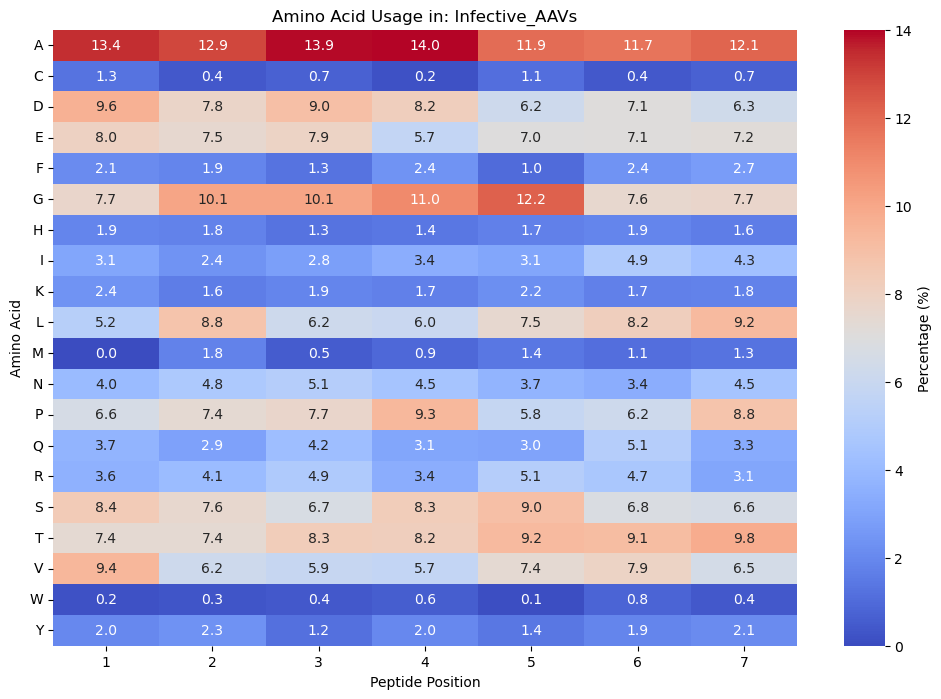

In [7]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p005
top_100_inf_aavs = get_top_fragment(df, "Infective_AAVs", 1000, "BC_adjusted_count_ratio")

plot_amino_acid_heatmap(top_100_inf_aavs, "Infective_AAVs")
#plot_amino_acid_heatmap(df_p005, "Plasmid_Library")

In [1]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p005
top_100_inf_aavs = get_top_fragment(df, "Infecrtive_AAVs", 100, "BC_adjusted_count_ratio")

plot_amino_acid_heatmap(top_100_inf_aavs, "Cerebellum")

NameError: name 'df_p005' is not defined

In [3]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p007
top_100_inf_aavs = get_top_fragment(df, "Fimbria", 100, "BC_adjusted_count_ratio")

plot_amino_acid_heatmap(top_100_inf_aavs, "Fimbria")

NameError: name 'df_p007' is not defined

In [4]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p005
top_100_inf_aavs = get_top_fragment(df, "Fimbria", 100, "BC_adjusted_count_ratio")

plot_amino_acid_heatmap(top_100_inf_aavs, "Fimbria")

NameError: name 'get_top_fragment' is not defined